### Input data

Dataset from the Lammin Suo peatland station (Saint Petersburg, Russia) is available at Zenodo repository: https://doi.org/10.5281/zenodo.5060038

### Input and output directories:

In [107]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

work_dir = "/home/antonv/data/essd/PREP/READY_V2/"

# fig_dir = os.path.dirname(os.path.realpath(__file__))  # __file__ is undefined in Jupyter Notebook
fig_dir = os.path.join(globals()['_dh'][0], "fig")
# print(fig_dir)

### Some helper functions:

In [121]:
def prepare(f, v=False):
    df = pd.read_csv(f, comment='#')
    try:
        datetimes = pd.to_datetime(df["DATE_TIME"])
    except KeyError:
        df.rename(columns={"START_DATE": "DATE_TIME"}, inplace=True)
        datetimes = pd.to_datetime(df["DATE_TIME"])
    df["DATE_TIME"] = datetimes
    df.set_index("DATE_TIME", inplace=True)
    if v:
        df.info()
    return df


def calc_intra_annual(df, mean_col, min_col=None, max_col=None, v=False):
    df["DAY"] = df.index.dayofyear
    # next we need to eliminate Feb 29th: 
    df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb
    # display(df.loc[(df["DAY"] > 59) & (df["DAY"] <= 61)])
    
    params = ["mean", "std"]
    col_dict = {mean_col: params}
    if min_col is None:
        params.append("min")
    else:
        col_dict[min_col] = "min"
    if max_col is None:
        params.append("max")
    else:
        col_dict[max_col] = "max"
    
    out_df = df.groupby("DAY").agg(col_dict)
    out_df.columns = ("mean", "std", "min", "max")  # "flattens" grouped columns

    out_df["upper"] = out_df["mean"] + out_df["std"]
    out_df["lower"] = out_df["mean"] - out_df["std"]
    
    # checking if the upper and lower values are within max-min limits:
    out_df["upper"] = np.where(out_df["upper"] > out_df["max"], out_df["max"], out_df["upper"])
    out_df["lower"] = np.where(out_df["lower"] < out_df["min"], out_df["min"], out_df["lower"])
    if v:
        display(out_df)
    return out_df


def plot_intra_annual(df, ax):
    ax.plot(df.index, df["mean"], color="k", linewidth=1)
    ax.fill_between(df.index, df["upper"], df["lower"], color="lightgrey")
    ax.plot(df.index, df["max"], color="grey", linewidth=1)
    ax.plot(df.index, df["min"], color="grey", linewidth=1)

    
def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

        
def monthly_ticks(ax, crop=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))  # 16 is a slight approximation since months differ in number of days

    ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")
    ax.xaxis.get_minor_ticks()[-1].set_visible(False)
    if crop:
        ax.xaxis.get_minor_ticks()[0].set_visible(False)


### General font and fig size settings:

In [3]:
cm = 1 / 2.54  # inches to cm
wu = 8.5*cm  # width unit
hu = 6*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=LEAST_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Settings for Pandas: calendar year -> hydrological year

In [4]:
SHIFT = 2  # to start hydrological year from November (more useful for Lammin Suo)
# SHIFT = 3  # to start hydrological year from October

### Air temperature, intra-annual:

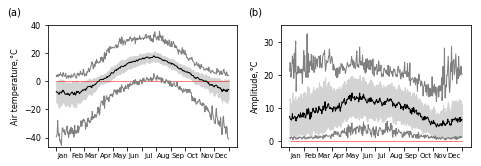

In [123]:
files = ("meteo_daily_1952-2020_1.csv", )

for f in files:
    
    tmp = prepare(os.path.join(work_dir, f))
    tmp = tmp.loc[tmp.index.year > 1966]  # observation timetable was changed starting from Jan 1967
    tmp["DAILY_AMPL"] = tmp["MAX_AIR_TEMP"] - tmp["MIN_AIR_TEMP"]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(2*wu, 1*hu)
    
    ######################## Daily temperatures:
    df = calc_intra_annual(tmp, "MEAN_AIR_TEMP", min_col="MIN_AIR_TEMP", max_col="MAX_AIR_TEMP")
    plot_intra_annual(df, ax1)
    ax1.hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
    ax1.set_ylim([-47, +40])
    # ax1.set_xlabel("Day of year")
    monthly_ticks(ax1, crop=True)
    ax1.set_ylabel("Air temperature,°C")

    ######################## Daily amplitudes:
    df = calc_intra_annual(tmp, "DAILY_AMPL")
    plot_intra_annual(df, ax2)
    
    ax2.hlines(y=0, xmin=1, xmax=365, linewidth=0.5, color='r')
    ax2.set_ylim([-2, +35])
    # ax2.set_xlabel("Day of year")
    monthly_ticks(ax2, crop=True)
    ax2.set_ylabel("Amplitude,°C")
    
    ax1.text(-0.14, 1.15, "(a)", transform=ax1.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
    ax2.text(-0.1, 1.15, "(b)", transform=ax2.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
    
    fig.tight_layout()
    
    fig_path = os.path.join(fig_dir, "test_01.png")
    plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")



### Air temperature, trends:

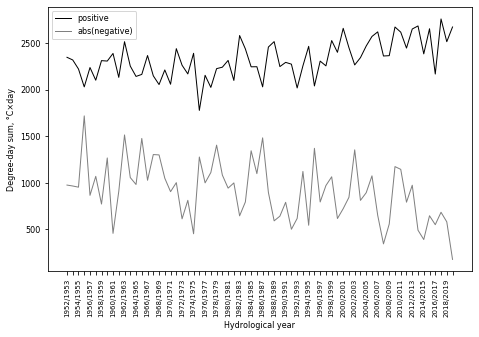

In [6]:
files = ("meteo_daily_1952-2020_1.csv", )

tmp = prepare(os.path.join(work_dir, f))

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 2*hu)

def plot_row(tmp, ax, start, end):
    df = tmp.loc[(tmp.index.year >= start) & (tmp.index.year <= end)]

    df["PDD"] = df["MEAN_AIR_TEMP"].clip(lower=0)  # for positive degree-day sums
    df["NDD"] = df["MEAN_AIR_TEMP"].clip(upper=0)  # for negative degree-day sums
    df["NDD"] = abs(df["NDD"])

    df = df.resample("M").sum()
    df = df.shift(SHIFT)
    df = df.resample("A").sum()
    df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
    df = df.iloc[1:]  # since first hydro year is truncated (there is no Oct-Dec of 1966 in dataset)
    # print(df)

    # ax.set_xlim([0, len(df["HYDRO_YEAR"])])
    # ax.set_ylim([-0.05, 0.5])
    ax.plot(df["HYDRO_YEAR"], df["PDD"], color="k", linewidth=1, label="positive")
    ax.plot(df["HYDRO_YEAR"], df["NDD"], color="grey", linewidth=1, label="abs(negative)")
    ax.set_ylabel("Degree-day sum, °C×day")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# plot_row(tmp, ax1, 1950, 1966) # observation timetable was changed starting from Jan1967
# plot_row(tmp, ax2, 1967, 2021) # the next part of the time series
plot_row(tmp, ax, 1950, 2021)

ax.legend()

ax.set_xlabel("Hydrological year")

for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)

fig.tight_layout()   

fig_path = os.path.join(fig_dir, "test_01x.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Precipitation, monthly:

<ipython-input-7-c6dd932b922b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
<ipython-input-7-c6dd932b922b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)


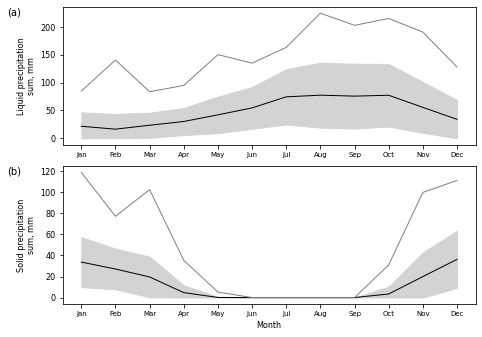

In [7]:
f = "precipitation_daily_1952-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["GAUGE_NO"] == 1]  # the longest time series

df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)
df = df.resample('M').sum()
df["MONTH"] = df.index.month

mean = df.groupby(["MONTH"]).mean()
# print(mean)
std = df.groupby(["MONTH"]).std()
# print(std)
max_df = df.groupby(["MONTH"]).max()
# print(max_df)
min_df = df.groupby(["MONTH"]).min()  # contains zeroes only, useless
# print(min_df)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

def plot_prec(ax, mean, std, max_df, col_name):
    ax.plot(mean.index, mean[col_name], color="k", linewidth=1)
    upper_list = mean + std
    # upper_list.replace(0, np.nan, inplace=True)
    lower_list = mean - std
    lower_list = lower_list.clip(lower=0)
    ax.fill_between(mean.index, upper_list[col_name], lower_list[col_name], color="lightgrey")
    ax.plot(mean.index, max_df[col_name], color="grey", linewidth=1)

plot_prec(ax[0], mean, std, max_df, "P_LIQUID")
plot_prec(ax[1], mean, std, max_df, "P_SOLID")

ax[-1].set_xlabel("Month")
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
for a in ax:
    plt.sca(a)
    plt.xticks(np.linspace(1, 12, num=len(months)), months)

ax[0].set_ylabel("Liquid precipitation\nsum, mm")
ax[1].set_ylabel("Solid precipitation\nsum, mm")
mark_axes(ax, py=1.0)

fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_02x.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Precipitation:

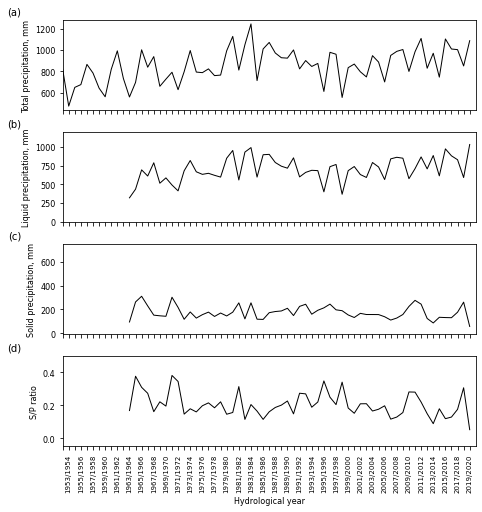

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

f = "precipitation_daily_1952-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["GAUGE_NO"] == 1]

df["P_TOTAL"] = df["PRECIPITATION"]
df["P_LIQUID"] = np.where(df["SOLID"] == 0, df["PRECIPITATION"], np.nan)
df["P_SOLID"] = np.where(df["SOLID"] == 1, df["PRECIPITATION"], np.nan)
df = df.resample('M').sum()
# print(df)

# Shifting all the columns to obtain hydrological years instead of calendar:
df["P_TOTAL"] = df["P_TOTAL"].shift(SHIFT)
df["P_LIQUID"] = df["P_LIQUID"].shift(SHIFT)
df["P_SOLID"] = df["P_SOLID"].shift(SHIFT)
# print(df)

df = df.resample('Y').sum()
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[1:]  # since first hydro year is truncated (there is no Oct-Dec of 1951 in dataset)

df.loc[df["P_LIQUID"] == 0, "P_LIQUID"] = np.nan
df.loc[df["P_SOLID"] == 0, "P_SOLID"] = np.nan

df["SP"] = df["P_SOLID"] / df["P_TOTAL"]  # S/P ratio
df.loc[df["SP"] == 0, "SP"] = np.nan
# print(df)

fig, ax = plt.subplots(4, 1)
fig.set_size_inches(2*wu, 3*hu)

ax[0].set_xlim([0, len(df["HYDRO_YEAR"])])
ax[0].plot(df["HYDRO_YEAR"], df["P_TOTAL"], color="k", linewidth=1)
ax[0].set_ylabel("Total precipitation, mm")

ax[1].set_xlim([0, len(df["HYDRO_YEAR"])])
ax[1].set_ylim([-10, 1200])
ax[1].plot(df["HYDRO_YEAR"], df["P_LIQUID"], color="k", linewidth=1)
ax[1].set_ylabel("Liquid precipitation, mm")

ax[2].set_xlim([0, len(df["HYDRO_YEAR"])])
ax[2].set_ylim([-10, 750])
ax[2].plot(df["HYDRO_YEAR"], df["P_SOLID"], color="k", linewidth=1)
ax[2].set_ylabel("Solid precipitation, mm")

ax[3].set_xlim([0, len(df["HYDRO_YEAR"])])
ax[3].set_ylim([-0.05, 0.5])
ax[3].plot(df["HYDRO_YEAR"], df["SP"], color="k", linewidth=1)
ax[3].set_ylabel("S/P ratio")

ax[-1].set_xlabel("Hydrological year")

for a in ax[:3]:
    for tick in a.get_xticklabels()[::1]:
        tick.set_visible(False)
for tick in ax[-1].get_xticklabels():
    tick.set_rotation(90)
for tick in ax[-1].get_xticklabels()[0::2]:
    tick.set_visible(False)

mark_axes(ax)

fig.subplots_adjust(bottom=0.4)
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_02.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Snow surveys:

Trend eqn:  
-0.5189 x + 1106


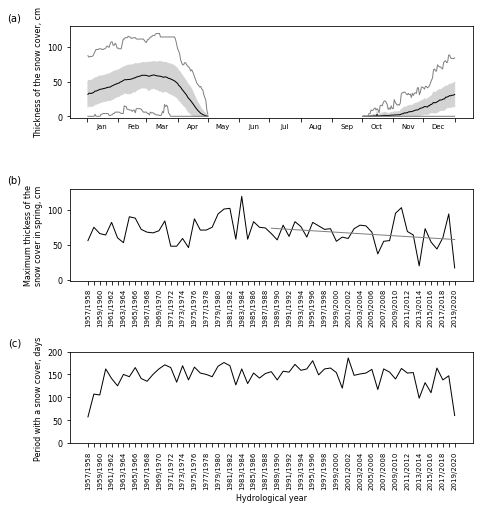

In [124]:
f = "meteo_daily_1952-2020_1.csv"

SHIFT = 2  # to start the hydrological year in November

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(2*wu, 3*hu)

tmp = prepare(os.path.join(work_dir, f))

################### Thickness of the snow cover:
df = calc_intra_annual(tmp, "SNOW_THICKNESS")
plot_intra_annual(df, ax[0])
ax[0].set_ylim([-2, 130])
    
# ax[0].set_xlabel("Day of year")
monthly_ticks(ax[0], crop=True)
ax[0].set_ylabel("Thickness of the snow cover, cm")

################### Max snow cover thickness during the spring:
df = tmp.loc[tmp.index.month < 6]
df = df.resample("A")["SNOW_THICKNESS"].agg(["max"])
df["YEAR"] = df.index.year
# df = df.loc[df["YEAR"] > 1985]
df.dropna(inplace=True)
# print("LENGTH", len(df.index))
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[1:]  # 1956/1957 is not available, observation started only from Jan 1957

ax[1].plot(df["HYDRO_YEAR"], df["max"], color="k", linewidth=1, label="Thickness")

df = df.loc[df["YEAR"] > 1988]
df.dropna(inplace=True)
fit = np.polyfit(df["YEAR"], df["max"], 1)
fit_fn = np.poly1d(fit)
print("Trend eqn:", fit_fn)
df["predicted"] = df["YEAR"] * fit[0] + fit[1]

ax[1].plot(df["HYDRO_YEAR"], df["predicted"], color="grey", linewidth=1, label="Trend since 1988")
ax[1].set_ylabel("Maximum thickess of the\nsnow cover in spring, cm")
ax[1].set_ylim([-1, 130])
# ax2.set_xlim([0, len(df["HYDRO_YEAR"])])

################### Days with the snow cover:
df = tmp
df["DAY"] = np.where(df["SNOW_THICKNESS"] > 0, 1, 0)

df = df.resample("M")["DAY"].agg(["sum"])
df["DAY_SHIFT"] = df["sum"].shift(SHIFT)

df = df.resample("A")["DAY_SHIFT"].agg(["sum"])
df["sum"] = np.where(df["sum"] == 0, np.nan, df["sum"])
df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
df = df.iloc[6:]
# print("LENGTH", len(df.index))

ax[2].plot(df["HYDRO_YEAR"], df["sum"], color="k", linewidth=1, label="")
ax[2].set_xlabel("Hydrological year")
ax[2].set_ylabel("Period with a snow cover, days")
# ax3.set_xlim([0, len(df["HYDRO_YEAR"])])
ax[2].set_ylim([-1, 200])

for a in (ax[1], ax[2]):
    for tick in a.get_xticklabels():
        tick.set_rotation(90)
    for tick in a.get_xticklabels()[1::2]:
        tick.set_visible(False)

mark_axes(ax, px=-0.12)
    
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_03.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Peat temperatures:

Trend slope for the surface: 0.65°C/decade
Trend slope for the depth of 320 cm: 0.23°C/decade


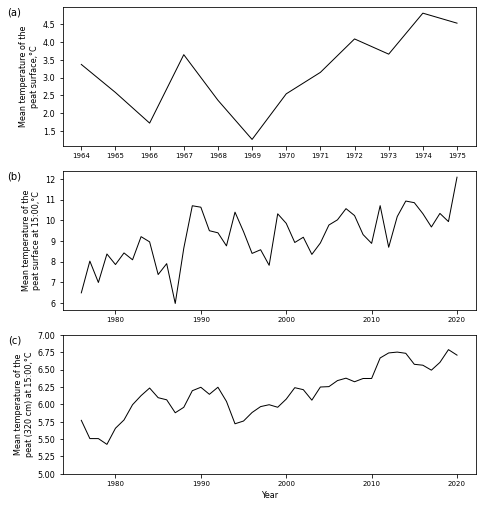

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(2*wu, 3*hu)

##### Daily series:
f = "peat-temp_daily_1960-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
tmp = tmp.loc[tmp["DEPTH"] == 0]
tmp = tmp.loc[tmp["OBS_TYPE"] == "avg"]
tmp = tmp.loc[tmp.index.year < 1976]  # 1976 is non-complete

for site in (1, ):  # site 2 was observed only during summertime, we won't use it
    df = tmp.loc[tmp["SITE"] == site]
    df = df.resample("A")["PEAT_TEMP"].agg(["mean"])
    # print(df)
    ax[0].plot(df.index.year, df["mean"], color="k", linewidth=1, label="Site %s" % site)
    ax[0].xaxis.set_ticks(np.arange(df.index.year.min(), df.index.year.max()+1, 1))

ax[0].set_ylabel("Mean temperature of the\npeat surface,°C")
    
##### "Hourly" series:

f = "peat-temp_hourly_1976-2020.csv"

tmp = prepare(os.path.join(work_dir, f))

tmp = tmp.loc[tmp["QC"] != 0]
tmp = tmp.loc[tmp.index.hour == 15]
tmp = tmp.loc[tmp["SITE"] == 1]

# PEAT SURFACE
df = tmp.loc[tmp["DEPTH"] == 0]
# print(df)
df = df.resample("A")["PEAT_TEMP"].agg(["mean", "max"])
# print(df)
ax[1].plot(df.index.year, df["mean"], color="k", linewidth=1)
# ax.plot(df.index.year, df["max"], color="k", linewidth=1, label="Site %s" % site)
ax[1].set_ylabel("Mean temperature of the\npeat surface at 15:00,°C")

fit = np.polyfit(df.index.year, df["mean"], 1)
# fit_fn = np.poly1d(fit)
print("Trend slope for the surface: %s°C/decade" % round(fit[0] * 10, 2))

# max available depth - 320 cm
df = tmp.loc[tmp["DEPTH"] == 320]
df = df.resample("A")["PEAT_TEMP"].agg(["mean"])
ax[2].plot(df.index.year, df["mean"], color="k", linewidth=1)
ax[2].set_ylabel("Mean temperature of the\npeat (320 cm) at 15:00,°C")
ax[2].set_ylim([5, 7])

fit = np.polyfit(df.index.year, df["mean"], 1)
# fit_fn = np.poly1d(fit)
print("Trend slope for the depth of 320 cm: %s°C/decade" % round(fit[0] * 10, 2))
# 
mark_axes(ax, px=-0.1, py=1)
ax[-1].set_xlabel("Year")

fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_04.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Freezing of the peat surface:

Site: скв.105
[1 0]
Site: скв.107а
[1 0 3 2]
Site: скв.108
[1 0]
Site: уч.4
[1 0 2 3]
Site: скв.103
[0 1]
Site: 106
[1 0]


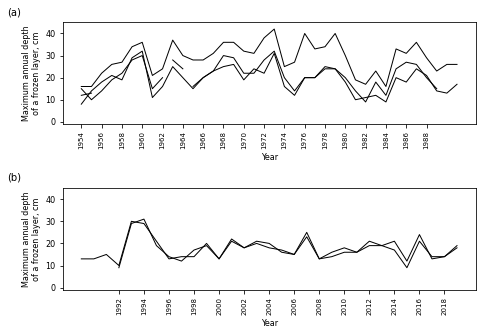

In [11]:
f = "1954-2019_thaw.csv"

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

sites = tmp["SITE"].unique()
# print(sites)

for site in sites:
    print("Site:", site)
    df = tmp.loc[tmp["SITE"] == site]
    t = df["TERRAIN"].unique()
    print(t)
    df = df.loc[df["TERRAIN"] == 1]
    df = df.resample("A")["FROZEN_CM"].agg(["max"])
    if site == "скв.108" or site == "скв.105" or site == "скв.107а" or site == "уч.4":  # OH, NO! the series is interrupted after 1991!
        ax1.plot(df.index.year, df["max"], color="k", linewidth=1)
        ax1.xaxis.set_ticks(np.arange(df.index.year.min(), df.index.year.max()+1, 2))
    if site == "скв.103" or site == "106":
        ax2.plot(df.index.year, df["max"], color="k", linewidth=1)
        ax2.xaxis.set_ticks(np.arange(df.index.year.min(), df.index.year.max()+1, 2))
        
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

for ax in (ax1, ax2):
    ax.set_ylim([-1, 45])

    ax.set_ylabel("Maximum annual depth\nof a frozen layer, cm")
    ax.set_xlabel("Year")

ax1.text(-0.1, 1.15, "(a)", transform=ax1.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
ax2.text(-0.1, 1.15, "(b)", transform=ax2.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')

fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_05.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Evapotranspiration:

<ipython-input-12-09e057d5a2bd>:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks(np.linspace(9, 33, num=len(months)), months)


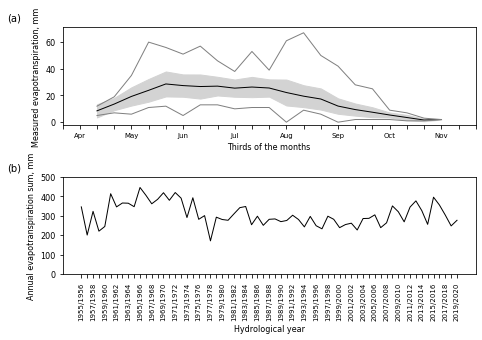

In [12]:
f = "evaporation_10d_1956-2020.csv"

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))

df = tmp.loc[tmp["SITE"] == 1]  # the longest time series

# INTRA_ANNUAL VARIABILITY:

df["MONTH"] = df.index.month
# getting the number of a 10-day period of a month:
df["D"] = 1
df.loc[df.index.day > 10, "D"] = 2
df.loc[df.index.day > 20, "D"] = 3
df["10d"] = (df["MONTH"] - 1) * 3 + df["D"]  # number of a 10-day period within a year
# print(df)

mean_list = []
std_list = []
max_list = []
min_list = []
day_list = []

for i in range(1, 37):  # there are 36 10-day period in a year
    df_d = df.loc[df["10d"] == i]
    
    if not df_d.empty:
        # print(df_d)
        mean_et = df_d["ET"].mean()
        std_et = df_d["ET"].std()
        max_et = df_d["ET"].max()
        min_et = df_d["ET"].min()
    else:
        mean_et = np.nan
        std_et = np.nan
        max_et = np.nan
        min_et = np.nan
        
    mean_list.append(mean_et)
    std_list.append(std_et)
    max_list.append(max_et)
    min_list.append(min_et)
    day_list.append(i)

upper_list = [sum(x) for x in zip(mean_list, std_list)]
lower_list = [x[0] - x[1] for x in zip(mean_list, std_list)]
    
ax1.plot(day_list, mean_list, color="k", linewidth=1)
ax1.fill_between(day_list, upper_list, lower_list, color="lightgrey")
ax1.plot(day_list, max_list, color="grey", linewidth=1)
ax1.plot(day_list, min_list, color="grey", linewidth=1)
ax1.set_ylim([-2, 71])

ax1.set_xlim([9, 33])
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
months = ["", 'Apr', "", "", 'May', "", "", 'Jun',"", "",  'Jul',"", "",  'Aug',"", "",  'Sep',"", "",  'Oct',"", "",  'Nov', "", ""]
plt.sca(ax1)
plt.xticks(np.linspace(9, 33, num=len(months)), months)
ax1.set_xticks(np.linspace(9, 33, num=len(months)), months)

ax1.set_xlabel("Thirds of the months")
ax1.set_ylabel("Measured evapotranspiration, mm")
# ax1.text(-0.14, 1.15, "(a)", transform=ax1.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')    

# INTER-ANNUAL VARIABILITY:
df = df.resample("A")["ET"].agg(["sum"])

df["HYDRO_YEAR"] = (df.index.year - 1).astype(str) + "/" + df.index.year.astype(str)
# print(df)

ax2.plot(df["HYDRO_YEAR"], df["sum"], color="k", linewidth=1)
ax2.set_ylim([-2, 500])
ax2.set_xlabel("Hydrological year")
ax2.set_ylabel("Annual evapotranspiration sum, mm")
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels()[1::2]:
    tick.set_visible(False)

mark_axes((ax1, ax2))

fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_06.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


### Runoff:

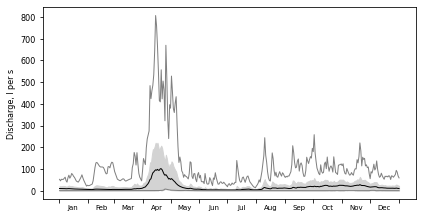

In [125]:
f = "1950-2018_runoff.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1.5*hu)

tmp = prepare(os.path.join(work_dir, f))

# RIV = "W1_RUNOFF"
RIV = "S_RUNOFF"

df = calc_intra_annual(tmp, RIV)
plot_intra_annual(df, ax)
# ax.plot(df.index, df["W1_RUNOFF"], color="k", linewidth=1)
# ax.set_ylim([-2, 500])
# ax.set_xlabel("Day of year")
monthly_ticks(ax, crop=True)
ax.set_ylabel("Discharge, l per s")
# ax.legend()

fig_path = os.path.join(fig_dir, "test_09.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

/home/antonv/data/essd/PREP/READY_V2/1950-2018_runoff.csv


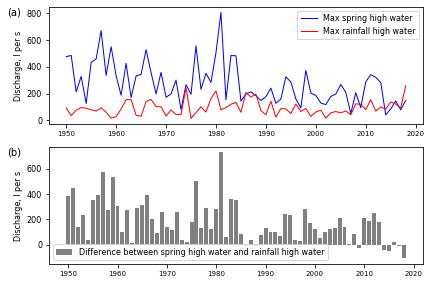

In [14]:
f = "1950-2018_runoff.csv"
print(os.path.join(work_dir, f))

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

# RIV = "W1_RUNOFF"
RIV = "S_RUNOFF"

# spring max discharges:
df = tmp.loc[(tmp.index.dayofyear >= 50) & (tmp.index.dayofyear < 135)] 
# print(df)
max_df = df.groupby(df.index.year).max()
# print(max_df)
ax[0].plot(max_df.index, max_df[RIV], color="b", linewidth=1, label="Max spring high water")

# max summer discharges:
df = tmp.loc[tmp.index.dayofyear >= 135]
rain_df = df.groupby(df.index.year).max()
ax[0].plot(rain_df.index, rain_df[RIV], color="r", linewidth=1, label="Max rainfall high water")

diff = max_df[RIV] - rain_df[RIV]
ax[1].bar(rain_df.index, diff, color="grey", linewidth=1, label="Difference between spring high water and rainfall high water")

ax[0].set_ylabel("Discharge, l per s")
ax[1].set_ylabel("Discharge, l per s")

ax[0].legend()
ax[1].legend(loc=3)

mark_axes(ax, px=-0.075, py=1)

fig_path = os.path.join(fig_dir, "test_10.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Groundwater temperature:

All the gw-wells in the dataset: [359, 360, 362, 364, 365, 366, 367, 369, 374, 375, 376, 377, 378, 379, 386, 387, 388, 389, 390]
Well #359 - 1661 observations
Well #360 - 1656 observations
Well #362 - 317 observations
Well #364 - 1647 observations
Well #365 - 1661 observations
Well #366 - 1661 observations
Well #367 - 1661 observations
Well #369 - 1639 observations
Well #374 - 1639 observations
Well #375 - 1661 observations
Well #376 - 1661 observations
Well #377 - 1661 observations
Well #378 - 1526 observations
Well #379 - 1661 observations
Well #386 - 386 observations
Well #387 - 409 observations
Well #388 - 409 observations
Well #389 - 409 observations
Well #390 - 403 observations
[359, 365, 366, 367, 375, 376, 377, 379]


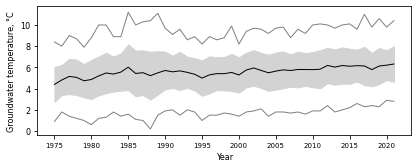

In [15]:
f = "groundwater-temp_daily_1974-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["GW_WELL"].unique())
print("All the gw-wells in the dataset:", wells)
"""
# plots separately all the gw-wells with the longest time series:
for w in wells:
    df = tmp.loc[tmp["GW_WELL"] == w]
    obs_num = len(df.index)
    print("Well #%s - %s observations" % (w, len(df.index)))
    # print(w, df.index[0], df.index[-1])
    df = df.resample("A").mean()
    # print("Well #%s - %s years" % (w, len(df.index)))
    # if len(df.index) >= 46:
    if obs_num >= 1661:
        ax.plot(df.index, df["GW_TEMP"], linewidth=1, label="Well #%s" % w)
ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_GW_TEMP.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")
"""
longest_series = []
for w in wells:
    df = tmp.loc[tmp["GW_WELL"] == w]
    obs_num = len(df.index)
    print("Well #%s - %s observations" % (w, len(df.index)))
    if obs_num >= 1661:
        longest_series.append(w)
print(longest_series)

df = tmp.loc[tmp["GW_WELL"].isin(longest_series)]
df = df.resample("A")["GW_TEMP"].agg(["mean", "max", "min", "std"])
df["upper"] = df["mean"] + df["std"]
df["lower"] = df["mean"] - df["std"]

plot_intra_annual(df, ax)
ax.set_xlabel("Year")
ax.set_ylabel("Groundwater temperature, °C")

fig_path = os.path.join(fig_dir, "test_GW_TEMP.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

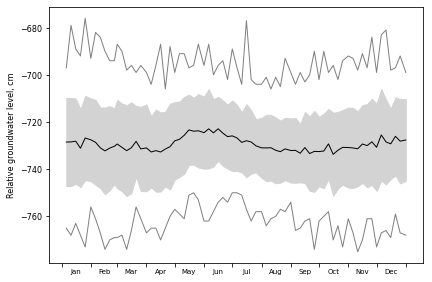

In [115]:
f = "groundwater-level_daily_1964-1986.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

tmp = tmp.loc[tmp["GW_WELL"] == 377]  # this well is located on the dome

# in some years there were daily observations, in some 10-day
# we need only 10-day observation to remain:
tmp["LDAY"] = tmp.index + MonthEnd(0)  # the last day of the month
tmp["DEL"] = ~tmp.index.day.isin((5, 10, 15, 20, 25)) & ~(tmp.index == tmp["LDAY"])
tmp = tmp.loc[~tmp["DEL"]]
# display(tmp)

# next we need to merge 29th Feb with the 28ths
# otherwise it breaks the behaviour of the calc_intra_annual function
tmp.index = np.where((tmp.index.month == 2) & (tmp.index.day == 29), tmp.index - timedelta(days=1), tmp.index)
# display(tmp.loc[(tmp.index.month == 2) & (tmp.index.day > 27)])  # every row should have the index of "YYYY-02-28"

df = calc_intra_annual(tmp, "GW_LEVEL")
plot_intra_annual(df, ax)

ax.set_ylabel("Relative groundwater level, cm")
# ax.set_xlabel("Day of year")
monthly_ticks(ax)

fig_path = os.path.join(fig_dir, "test_groundwater-level-intra.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


### Swamp-water wells:

#### Some statistics first:

In [16]:
f = "swamp-water-level_daily_1950-2020.csv"

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["SW_WELL"].unique())
num = len(wells)
print("All the sw-wells in the dataset (%s):" % num, wells)

for w in wells:
    df = tmp.loc[tmp["SW_WELL"] == w]
    obs_num = len(df.index)
    df = df.resample("A").mean()
    print("Well #%s - %s years - %s - %s (%s observations)" % (w, len(df.index), df.index.date[0], df.index.date[-1], obs_num))

All the sw-wells in the dataset (23): ['101', '102', '102a', '103', '104', '105', '106', '107', '107a', '107b', '108', '109', '210', '211', '212', '313', '314', '315', '316', '317', '318', '319', 'Dve Sestry Lake']
Well #101 - 71 years - 1950-12-31 - 2020-12-31 (15179 observations)
Well #102 - 40 years - 1950-12-31 - 1989-12-31 (13028 observations)
Well #102a - 46 years - 1975-12-31 - 2020-12-31 (4129 observations)
Well #103 - 71 years - 1950-12-31 - 2020-12-31 (15176 observations)
Well #104 - 71 years - 1950-12-31 - 2020-12-31 (21530 observations)
Well #105 - 40 years - 1950-12-31 - 1989-12-31 (12778 observations)
Well #106 - 71 years - 1950-12-31 - 2020-12-31 (14908 observations)
Well #107 - 40 years - 1950-12-31 - 1989-12-31 (8825 observations)
Well #107a - 6 years - 1970-12-31 - 1975-12-31 (849 observations)
Well #107b - 51 years - 1970-12-31 - 2020-12-31 (4401 observations)
Well #108 - 71 years - 1950-12-31 - 2020-12-31 (11018 observations)
Well #109 - 71 years - 1950-12-31 - 2020

Longest time series are from the wells: ['109']


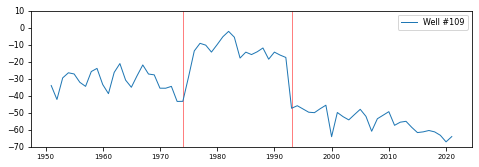

In [23]:
f = "swamp-water-level_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wells = sorted(tmp["SW_WELL"].unique())
num = len(wells)

wl = "109"

longest_series = []
for w in wells:
    df = tmp.loc[tmp["SW_WELL"] == w]
    df = df.resample("A").mean()
    # if len(df.index) == 71:
    if w == wl:
        longest_series.append(w)
        ax.plot(df.index, df["SW_LEVEL"], linewidth=1, label="Well #%s" % w)
print("Longest time series are from the wells:", longest_series)
ax.set_ylim((-70, 10))

ax.vlines(x=pd.to_datetime("1993-01-01"), ymin=-70, ymax=10, linewidth=0.5, color='r')
ax.vlines(x=pd.to_datetime("1974-01-01"), ymin=-70, ymax=10, linewidth=0.5, color='r')

ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_SW_depth_%s.png" % wl)
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")


#### Intra-annual:

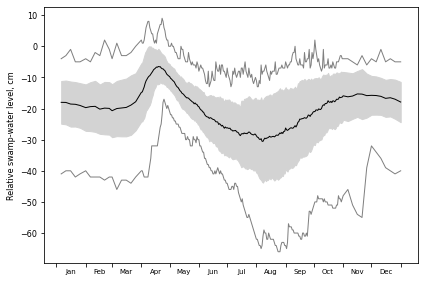

In [116]:
from pandas.tseries.offsets import MonthEnd
from datetime import timedelta

f = "swamp-water-level_daily_1950-2020.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 2*hu)

tmp = prepare(os.path.join(work_dir, f))
tmp.sort_index(inplace=True)

wl = "104"  # reference well

tmp = tmp.loc[tmp["SW_WELL"] == wl]

# the timetable of obervations was floating during the "cold" period
# in some years there were daily observations, in some 5-day
# we need only 5-day observation to remain:
tmp["LDAY"] = tmp.index + MonthEnd(0)  # the last day of the month
tmp["DEL"] = tmp.index.month.isin([1, 2, 3, 11, 12]) & ~tmp.index.day.isin((5, 10, 15, 20, 25)) & ~(tmp.index == tmp["LDAY"])
# display(tmp)
tmp = tmp.loc[~tmp["DEL"]]

# next we need to merge 29th Feb with the 28ths
# otherwise it breaks the behaviour of the calc_intra_annual function
tmp.index = np.where((tmp.index.month == 2) & (tmp.index.day == 29), tmp.index - timedelta(days=1), tmp.index)
# display(tmp.loc[(tmp.index.month == 2) & (tmp.index.day > 27)])


df = calc_intra_annual(tmp, "SW_LEVEL")
# display(df.loc[df.index > 55])
plot_intra_annual(df, ax)

ax.set_ylabel("Relative swamp-water level, cm")
# ax.set_xlabel("Day of year")
monthly_ticks(ax)

fig_path = os.path.join(fig_dir, "test_swamp-water-level-intra.png")
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")

### Surface elevation:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 1965-01-01 to 1995-01-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NO    254 non-null    object 
 1   WELL_TYPE  254 non-null    object 
 2   SURF_ELEV  254 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.9+ KB
['101', '102', '102a', '103', '104', '105', '106', '107', '107a', '107b', '108', '109', '210', '211', '212', '313', '314', '315', '316', '317', '318', '319', '359', '360', '361', '362', '363', '364', '365', '366', '367', '369', '374', '375', '376', '377', '378', '379', '386', '387', '388', '389', '390', 'Dve Sestry Lake']
44
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 1965-01-01 to 1995-01-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WELL_NO    7 non-null      object 
 1   WELL_TYPE  7 non-null      object 
 2   SURF_ELEV  7

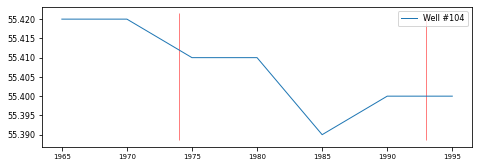

In [18]:
f = "surface-elevation_5y_1965-1995.csv"

fig, ax = plt.subplots()
fig.set_size_inches(2*wu, 1*hu)

tmp = pd.read_csv(os.path.join(work_dir, f), comment='#')
tmp["DATE_TIME"] = pd.to_datetime(tmp["DATE_TIME"], format='%Y')

tmp.set_index("DATE_TIME", inplace=True)
tmp.sort_index(inplace=True)
tmp.info()

wells = sorted(tmp["WELL_NO"].unique())
print(wells)
num = len(wells)
print(num)

wl = "104"

longest_series = []
for w in wells:
    df = tmp.loc[tmp["WELL_NO"] == w]
    if w == wl:
        df.info()
        longest_series.append(w)
        ax.plot(df.index, df["SURF_ELEV"], linewidth=1, label="Well #%s" % wl)
        # ax.set_xlim((pd.to_datetime("1960-01-01"), pd.to_datetime("1995-01-01")))
        
        ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        ymin, ymax = ax.get_ylim()
        ax.vlines(x=pd.to_datetime("1993-01-01"), ymin=ymin, ymax=ymax, linewidth=0.5, color='r')
        ax.vlines(x=pd.to_datetime("1974-01-01"), ymin=ymin, ymax=ymax, linewidth=0.5, color='r')

ax.legend()
fig.tight_layout()

fig_path = os.path.join(fig_dir, "test_surf-elev_%s.png" % wl)
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")